In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import blpapi
import scipy
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy import stats
#from xbbg import blp


path = '/Users/tobiastschuemperlin/Developer/Algorithmic_Trading/src/data/data pairs.csv'

# make a function to load data
def load_data(path):
    # load csv file in data pairs
    data = pd.read_csv(path, index_col=0, parse_dates=True)
    # rename column index to date
    data.index.name = 'date'
    return data

def find_cointegrated_pairs(data):
    ''' find from a list cointegrated pairs'''
    n = data.shape[1]
    keys = data.keys()
    pvalue_matrix = np.ones((n, n))
    pairs = []

    # Loop through each combination of assets
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            # Test for cointegration
            result = ts.coint(S1, S2)
            pvalue = result[1]

            # Store p-value in matrix
            pvalue_matrix[i, j] = pvalue

            # Add cointegrated pair to list (if p-value is less than 0.05)
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))

    # Sort cointegrated pairs by p-value in ascending order
    pairs.sort(key=lambda x: x[2])

    return pd.DataFrame(pairs)


def calc_dynamic_hedge_ratio_ols(data, window):
    """
    Calculates rolling hedge ratio using OLS
    """
    hedge_ratio = []
    for i in range(window, len(data)):
        # Estimate hedge ratio using OLS
        y = data.iloc[i-window:i,0]
        x = data.iloc[i-window:i,1]
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        hedge_ratio.append(model.params[1])

    spread_ols = data.iloc[window::, 0] - data.iloc[window::, 1] * hedge_ratio

    return hedge_ratio, spread_ols


def calc_bollinger_ols(data, window, std_dev):
    """
    Calculates rolling spread and bollinger bands
    """
    hedge_ratio, spread = calc_dynamic_hedge_ratio_ols(data, window)
    spread_mean = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    z_spread = (spread - spread_mean) / spread_std
    upper_band = spread_mean + std_dev * spread_std
    lower_band = spread_mean - std_dev * spread_std

    return spread, z_spread, spread_mean, upper_band, lower_band, hedge_ratio

def dynamic_trading_strategy_pairs_backtest(data, window, std_dev):

    spread, spread_z, spread_mean, spread_ub, spread_lb, hedge_ratio = calc_bollinger_ols(data, window, std_dev)
    data_strategy = data.copy()
    data_strategy = data_strategy.iloc[window:,:]
    data_strategy['zspread'] = spread_z
    data_strategy['position_long_series1'] = 0
    data_strategy['position_long_series2'] = 0
    data_strategy['position_short_series1'] = 0
    data_strategy['position_short_series2'] = 0

    data_strategy.loc[data_strategy.zspread>=spread_ub, ('position_short_series1', 'position_short_series2')] = [-1, 1] # Short spread
    data_strategy.loc[data_strategy.zspread<=spread_lb, ('position_long_series1', 'position_long_series2')] = [1, -1] # Buy spread
    data_strategy.loc[data_strategy.zspread<=0, ('position_short_series1', 'position_short_series2')] = 0 # Exit short spread
    data_strategy.loc[data_strategy.zspread>=0, ('position_long_series1', 'position_long_series2')] = 0 # Exit long spread
    data_strategy.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

    positions_Long = data_strategy.loc[:, ('position_long_series1', 'position_long_series2')]
    positions_Short = data_strategy.loc[:, ('position_short_series1', 'position_short_series2')]
    positions = np.array(positions_Long) + np.array(positions_Short)
    positions = pd.DataFrame(positions)

    # calc returns
    dailyret = data_strategy.loc[:, ('series1', 'series2')].pct_change()

    # calculate pnl
    pnl = (np.array(positions.shift())*np.array(dailyret)).sum(axis=1)
    pnl = pnl[~np.isnan(pnl)]

    # calc sharpe ratio of strategy
    sharpe_ratio = np.sqrt(252) * np.mean(pnl) / np.std(pnl)

    # plot equity curve
    plt.plot(np.cumsum(pnl))
    print(sharpe_ratio)




In [19]:

data = load_data('/Users/tobiastschuemperlin/Developer/Algorithmic_Trading/src/data/data pairs.csv')

pairs = find_cointegrated_pairs(data)

# choose pair wits smallest p-value in pairs
tickers_pairs = pairs.iloc[0,0:2]

# new data frame with only the two tickers
data_pairs = data[tickers_pairs]

# trading strategy using dynamic hedge ratio from OLS and upper and lower bound threshold from z-spread
# sell spread if z-score > threshold
# buy spread if z-score < threshold

# params
window = 20
threshold = 2


<AxesSubplot: >

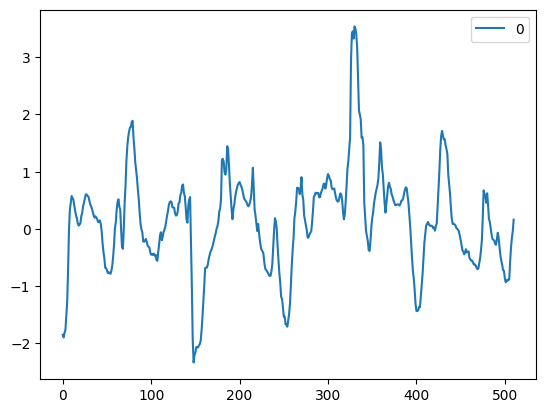

In [20]:

data_pairs = data_pairs.dropna()

# calc dynamic hedge ratio
hedge_ratio, spread_ols = calc_dynamic_hedge_ratio_ols(data_pairs, window=window)
pd.DataFrame(hedge_ratio).plot()


KeyError: "None of [Index(['series1', 'series2'], dtype='object')] are in the [columns]"

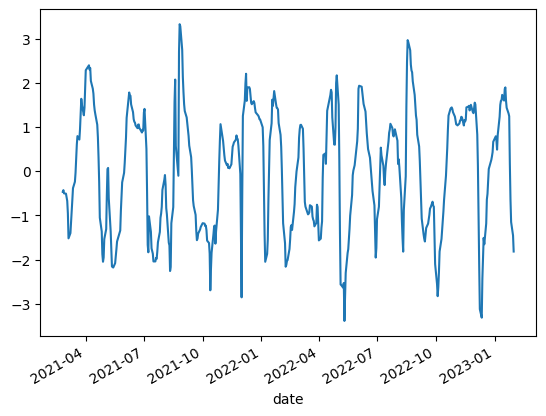

In [21]:

# calc z-spread
spread, z_spread, spread_mean, upper_band, lower_band, hedge_ratio = calc_bollinger_ols(data_pairs, window = window, std_dev = threshold)
z_spread.plot()

# backtest strategy
dynamic_trading_strategy_pairs_backtest(data_pairs, window=window, std_dev= threshold)